# Impport libraries

In [83]:
from google.colab import files    #to upload the file to google drive
import pandas as pd
import io
from scipy.stats import chi2_contingency
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.feature_selection import SelectKBest, chi2

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import QuantileTransformer

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Load and exploar Data set

In [2]:
# upload the CSV file to Google Colab environment.
uploaded = files.upload()

Saving fitness_class_2212.csv to fitness_class_2212.csv


In [84]:
# Read the CSV file using pandas.
df = pd.read_csv(io.BytesIO(uploaded['fitness_class_2212.csv']))

In [4]:
# View the data
df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [5]:
# display main information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


# Data preprocessing

**Nulls values**

In [85]:
df.isnull().sum()

booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

Only the weight column contains null values. We have chosen to use the Regression Imputation approch to fill the missing values given that months_as_member and weight are correlated

<ipython-input-86-79c96ad424e8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


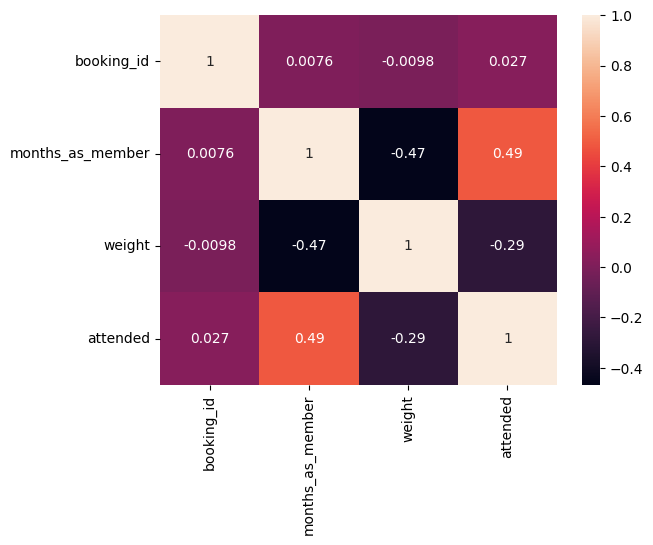

In [86]:
# Find the columns that are highly correlated with weight
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [87]:
# Create a new dataframe without missing values to train the model
train_data = df[df['weight'].notna()]

# Train a linear regression model
model = LinearRegression()
model.fit(train_data[['months_as_member']], train_data['weight'])

# Now use the trained model to predict missing values
missing_data = df[df['weight'].isna()]
missing_values_prediction = model.predict(missing_data[['months_as_member']])

# Now we can fill the missing values with the predicted ones in our original dataframe
df.loc[df['weight'].isna(), 'weight'] = missing_values_prediction

In [88]:
df.isnull().sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

## days_before column

days_before column contains strings with numbers embedded in them, we fixed that by extracting the numerical part using the str.extract() function with a regular expression.

In [89]:
df['days_before'] = df['days_before'].str.extract('(\d+)').astype(int)

In [90]:
# Check the column type
print(df['days_before'].dtype)

int64


## day_of_week

day_of_week column values are inconsistent and represent the same day in different ways. to fix this we standardize the data. This is done by converting all the text to lowercase and then replaceing abbreviated or different representations of the same day with a single chosen format

In [91]:
# Convert to lowercase
df['day_of_week'] = df['day_of_week'].str.lower()

# Remove all non-word characters (everything except numbers and letters)
df['day_of_week'] = df['day_of_week'].str.replace(r'\W', '', regex=True)

# Replace abbreviations/different representations with standard ones
df['day_of_week'] = df['day_of_week'].replace({'mon': 'monday', 'tue': 'tuesday', 'wed': 'wednesday',
                                               'thu': 'thursday', 'fri': 'friday', 'sat': 'saturday',
                                               'sun': 'sunday'})

In [92]:
# convert this column to category
df['day_of_week'] = df['day_of_week'].astype('category')

In [93]:
df['day_of_week'].value_counts()

friday       305
thursday     241
monday       228
sunday       213
saturday     202
tuesday      195
wednesday    116
Name: day_of_week, dtype: int64

## category

In [94]:
print(df['category'].unique())

['Strength' 'HIIT' 'Cycling' 'Yoga' '-' 'Aqua']


The hyphen must be substituted.   We choose to replace it with the a new catigory "missing"

In [95]:
# Replace '-' with NaN
df['category'] = df['category'].replace('-', np.nan)

df['category'].fillna('Missing', inplace=True)

In [96]:
print(df['category'].unique())

['Strength' 'HIIT' 'Cycling' 'Yoga' 'Missing' 'Aqua']


## Outliers

**Checking outliers using the Z-score method**

In [97]:
numerical_df = df.select_dtypes(include=[np.number])
z_scores = stats.zscore(numerical_df)

outliers = np.abs(z_scores) > 3

# print columns and number of outliers
for col, no_of_outliers in zip(numerical_df.columns, outliers.sum(axis=0)):
    print(f"{col}: {no_of_outliers} outliers")

booking_id: 0 outliers
months_as_member: 29 outliers
weight: 12 outliers
days_before: 1 outliers
attended: 0 outliers


**Using BoxPlot**

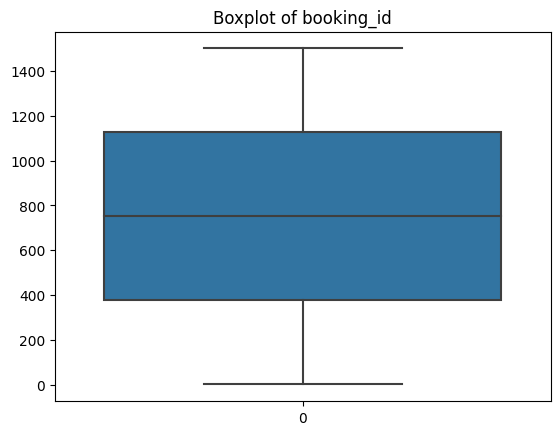

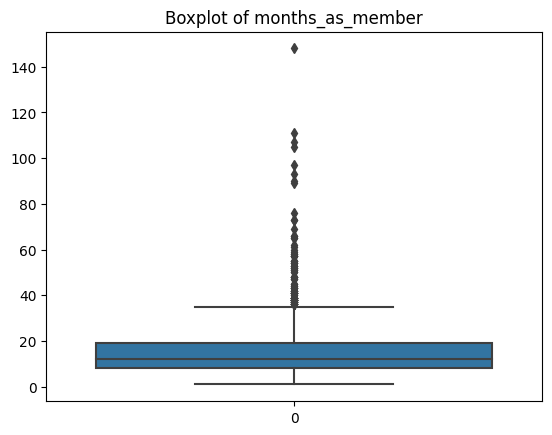

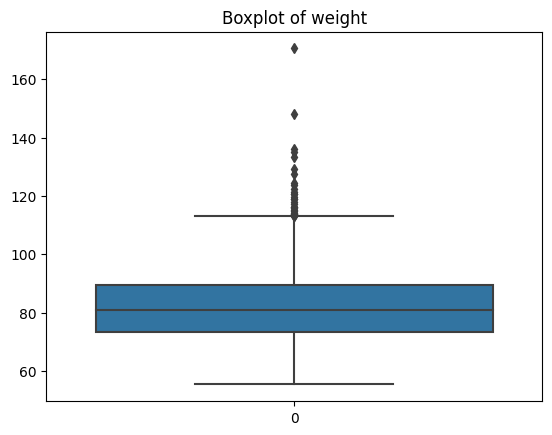

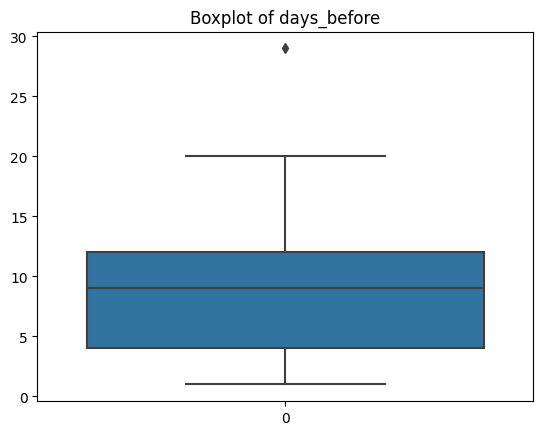

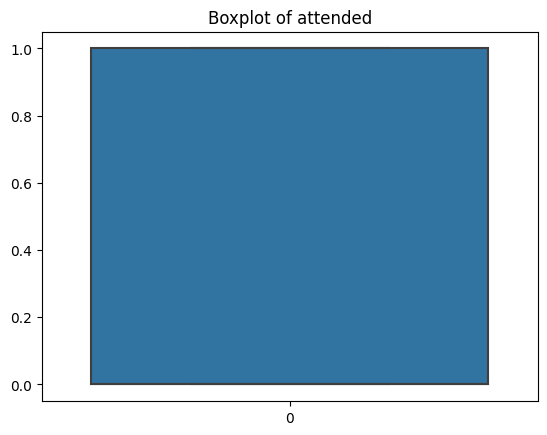

In [98]:
for col in numerical_df:
    plt.figure()
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

**Remove Outliers**

In [99]:
for col in numerical_df:
    df = df[(np.abs(stats.zscore(df[col])) < 2)]

In [100]:
numerical_df = df.select_dtypes(include=[np.number])
z_scores = stats.zscore(numerical_df)

outliers = np.abs(z_scores) > 3

# print columns and number of outliers
for col, no_of_outliers in zip(numerical_df.columns, outliers.sum(axis=0)):
    print(f"{col}: {no_of_outliers} outliers")

booking_id: 0 outliers
months_as_member: 9 outliers
weight: 0 outliers
days_before: 0 outliers
attended: 0 outliers


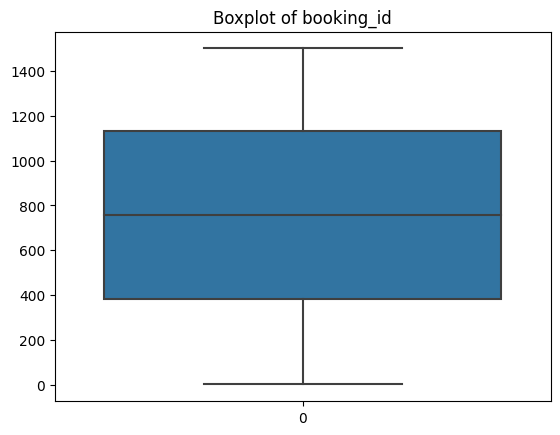

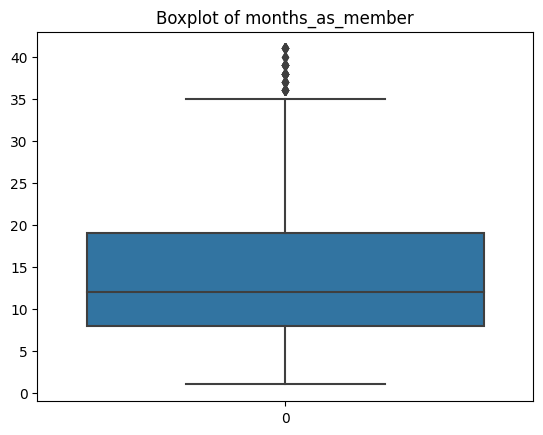

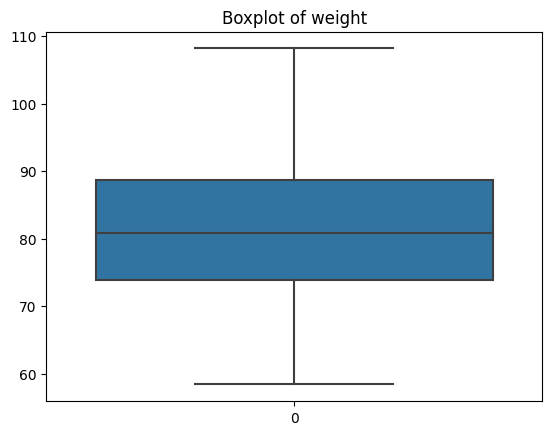

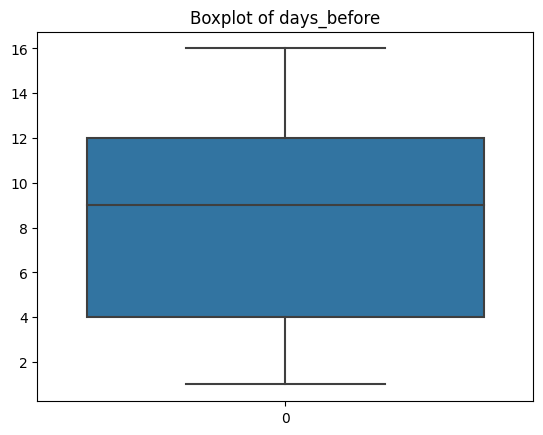

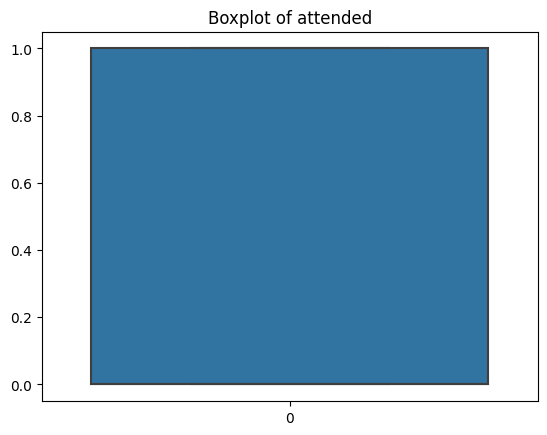

In [101]:
for col in numerical_df:
    plt.figure()
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Feature Engineering

**check the distribution**

<ipython-input-102-3dc74dffc934>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), bins=30)
<ipython-input-102-3dc74dffc934>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), bins=30)
<ipython-input-102-3dc74dffc934>:6: UserWarning: 

`distplot` is a depre

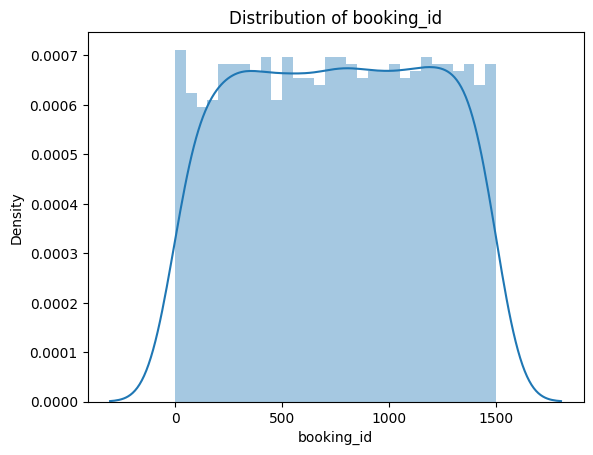

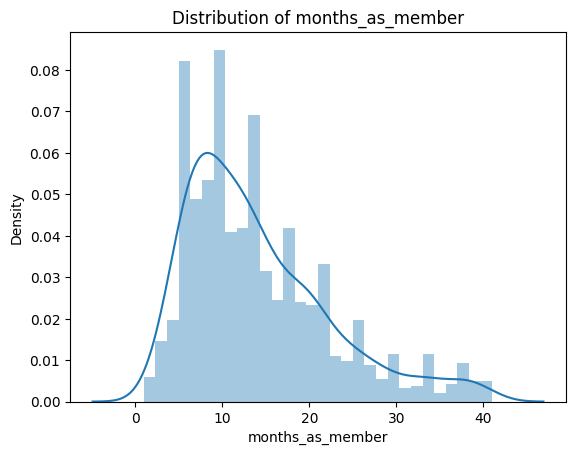

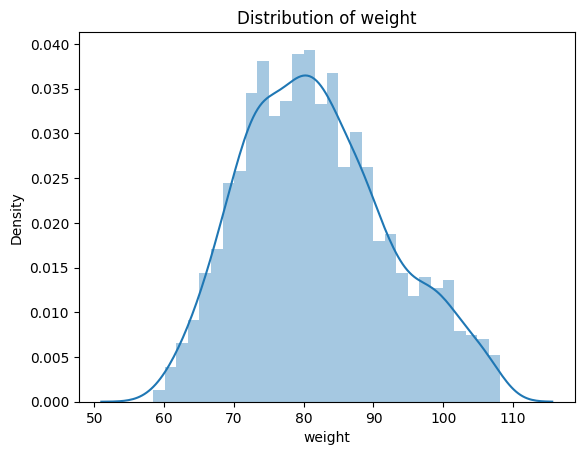

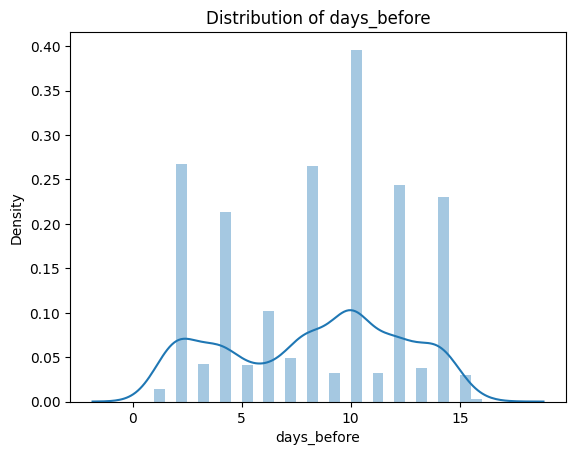

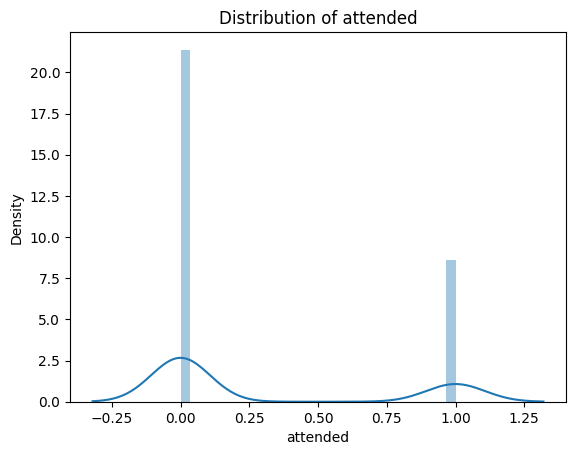

In [102]:
for column in df.select_dtypes(include=[np.number]).columns:
    # Create a new figure
    plt.figure()

    # Plot the distribution of the current column
    sns.distplot(df[column].dropna(), bins=30)

    # Set the title of the plot to be the same as the column name
    plt.title(f'Distribution of {column}')

plt.show()

**Months_as_member**

In [103]:
# Check if 'months_as_member' contains 0
contains_zero = (df['months_as_member'] == 0).any()
contains_zero

False

Using the Square Root Transformation due to the positive skewness (right skewness).

In [104]:
df['months_as_member'] = np.sqrt(df['months_as_member'])

**Days before**

In [105]:
# Check if days befor contains 0
contains_zero = (df['days_before'] == 0).any()
contains_zero

False

In [106]:
# Convert the Series to a NumPy array and reshape it
reshaped_values = df['days_before'].values.reshape(-1, 1)

# Perform quantile transformation
transformer = QuantileTransformer(output_distribution='normal')
transformed_values = transformer.fit_transform(reshaped_values)

# Update the 'days_before' column with the transformed values
df['days_before'] = transformed_values.flatten()

<ipython-input-107-c82db05a0dc9>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), bins=30)
<ipython-input-107-c82db05a0dc9>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), bins=30)
<ipython-input-107-c82db05a0dc9>:7: UserWarning: 

`distplot` is a depre

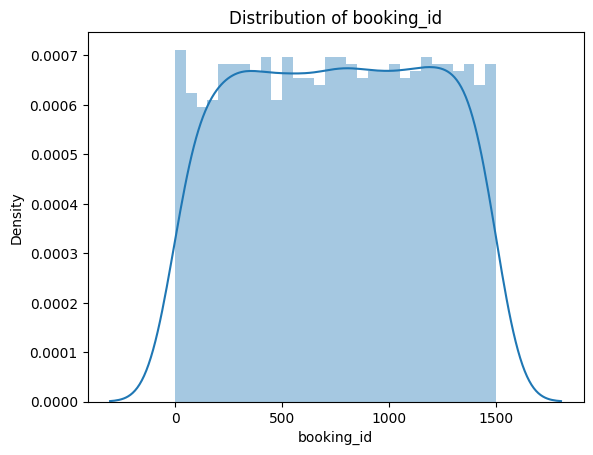

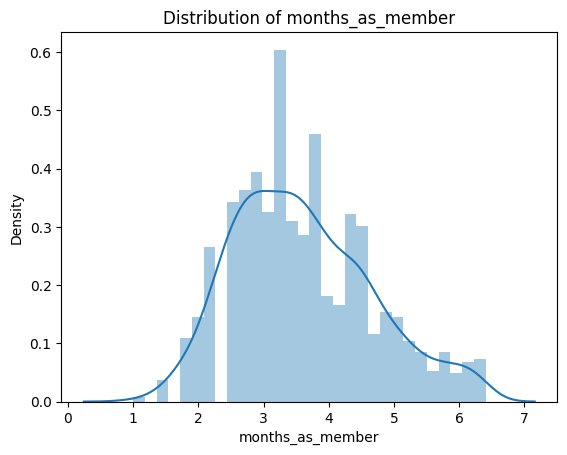

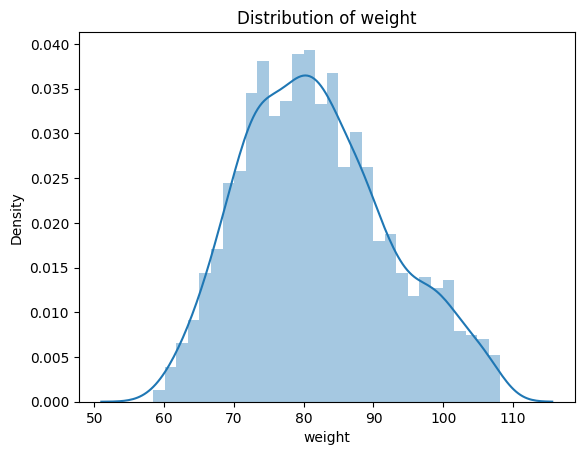

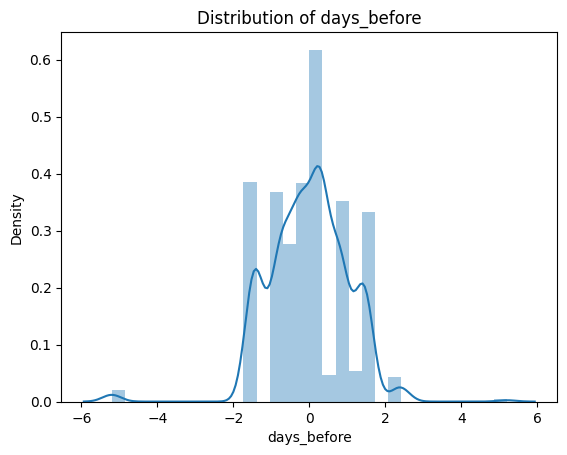

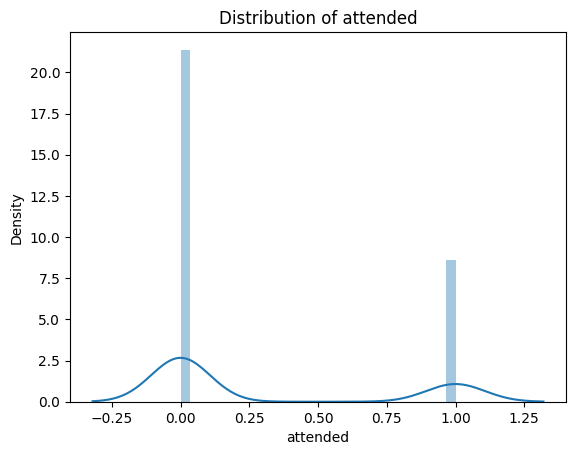

In [107]:
#checking step
for column in df.select_dtypes(include=[np.number]).columns:
    # Create a new figure
    plt.figure()

    # Plot the distribution of the current column
    sns.distplot(df[column].dropna(), bins=30)

    # Set the title of the plot to be the same as the column name
    plt.title(f'Distribution of {column}')

plt.show()

# Exploratory data analysis

Get summary statistics

In [108]:
print(df.describe())

        booking_id  months_as_member       weight  days_before     attended
count  1378.000000       1378.000000  1378.000000  1378.000000  1378.000000
mean    754.751814          3.598160    81.880212    -0.011369     0.287373
std     432.367954          1.066547    10.502220     1.039329     0.452701
min       1.000000          1.000000    58.420000    -5.199338     0.000000
25%     381.250000          2.828427    73.940000    -0.790168     0.000000
50%     757.500000          3.464102    80.920000     0.012546     0.000000
75%    1131.750000          4.358899    88.642500     0.800496     1.000000
max    1500.000000          6.403124   108.200000     5.199338     1.000000


## Visualize the data:

In [109]:
numerical_columns = df.select_dtypes(include=[np.number])

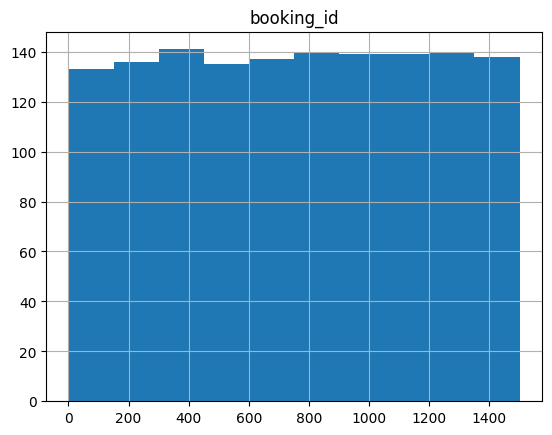

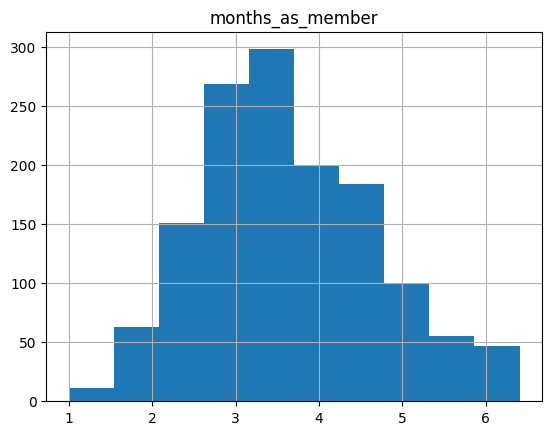

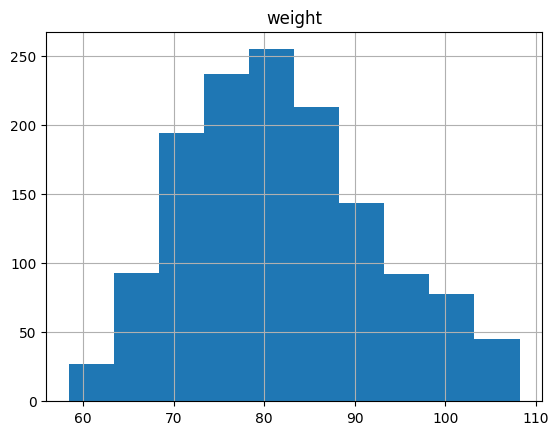

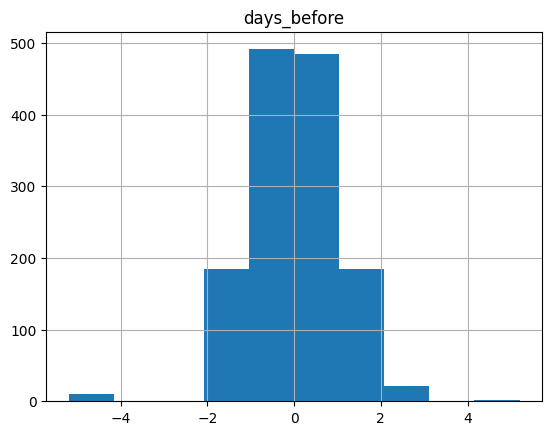

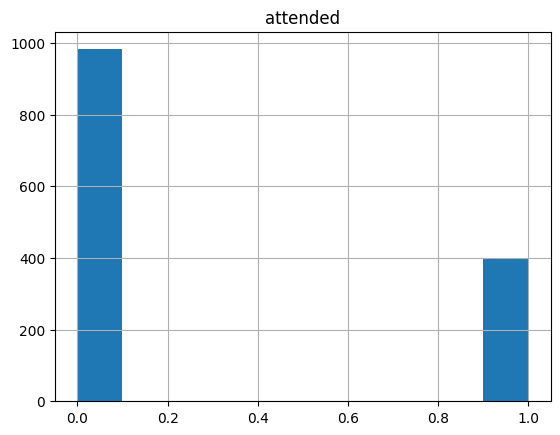

In [110]:
for col in numerical_columns:
    plt.figure()
    df[col].hist()
    plt.title(col)
    plt.show()

According to the attended chart, it seems that the data is unbalanced, since the number of observations with a value of 0 is almost twice as high as the number of observations with a value of 1.   This might result in accuracy issues while constructing the ML model.

## Correlations

Find correlations of categorical data
Source:https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/

**Using chi-square test of independence, which tests if there is a significant association between two categorical variables.**

In [111]:
day_of_week_corr=pd.crosstab(index=df['day_of_week'],columns=df['attended'])
print(day_of_week_corr)

attended       0   1
day_of_week         
friday       193  85
monday       153  58
saturday     134  53
sunday       125  63
thursday     157  68
tuesday      130  49
wednesday     90  20


In [112]:
day_of_week_corr_ChiSqResult = chi2_contingency(day_of_week_corr)
print("Chi2: ", day_of_week_corr_ChiSqResult[0])
print("p-value: ", day_of_week_corr_ChiSqResult[1])


Chi2:  9.114722997132787
p-value:  0.16722818968390582


Based on the test, as the p > 0.05 there is no significant correlation between attendance and the day of the week.

In [113]:
time_corr=pd.crosstab(index=df['time'],columns=df['attended'])
print(time_corr)

attended    0    1
time              
AM        733  317
PM        249   79


In [114]:
time_corr_ChiSqResult = chi2_contingency(time_corr)
print("Chi2: ", time_corr_ChiSqResult[0])
print("p-value: ", time_corr_ChiSqResult[1])

Chi2:  4.255525314735023
p-value:  0.03912284635577606


According to this test, As the p< 0.05 there is  a significant association between the time and attendance.

In [115]:
#Category
category_corr=pd.crosstab(index=df['category'],columns=df['attended'])
print(category_corr)

attended    0    1
category          
Aqua       49   20
Cycling   255  102
HIIT      418  179
Missing    11    1
Strength  162   57
Yoga       87   37


In [116]:
category_corr_ChiSqResult = chi2_contingency(category_corr)
print("Chi2: ", category_corr_ChiSqResult[0])
print("p-value: ", category_corr_ChiSqResult[1])

Chi2:  3.7576974939202734
p-value:  0.5848016158199865


According to this test, As P> 0.05 there is no association between the category and attendance.

**Numarical Data correlations**

<ipython-input-117-5927c2bf1f17>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


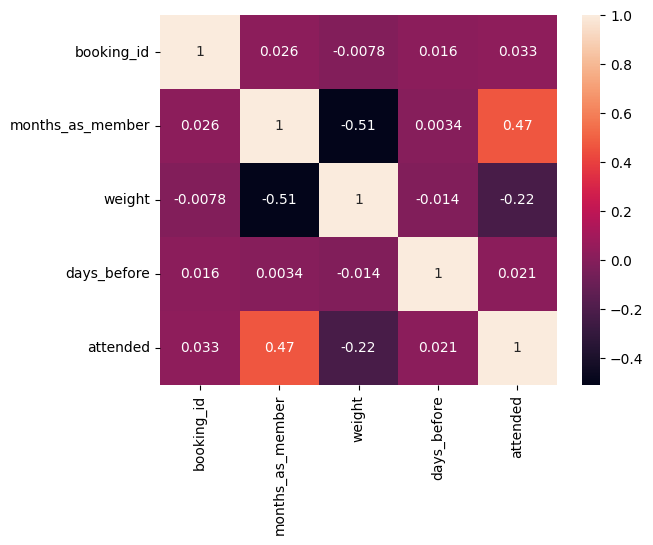

In [117]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# ML Classification model

In [276]:
# Choose the features (X) and the target (y)
X = df.drop('attended', axis=1)
y = df['attended']

**use one-hot incoding to convert catigorical features to numarical**

In [277]:
X = pd.get_dummies(X, columns=[ 'time' ,'day_of_week' , 'category'])

## Feature Selection

As the number of features is small we will just drop the booking_id

In [278]:
# Drop the 'booking_id' column
X = X.drop(['booking_id'], axis =1)

## Split the data

In [279]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Given that this is a binary classification task, Random Forests is an appropriate choice since it may reduce the risk of overfitting and typically provide higher accuracy.

# Models

In [280]:
# Create the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Predict the responses for the test set
y_pred = rfc.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7463768115942029
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       194
           1       0.59      0.46      0.52        82

    accuracy                           0.75       276
   macro avg       0.69      0.66      0.67       276
weighted avg       0.73      0.75      0.74       276



In [281]:
# Create the SVM model
svc = svm.SVC(kernel='linear', random_state=42)

# Fit the model to the training data
svc.fit(X_train, y_train)

# Predict the responses for the test set
y_pred = svc.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7608695652173914
              precision    recall  f1-score   support

           0       0.77      0.93      0.85       194
           1       0.69      0.35      0.47        82

    accuracy                           0.76       276
   macro avg       0.73      0.64      0.66       276
weighted avg       0.75      0.76      0.73       276



The models perform relatively well on predicting the class '0' (people who didn't attend), but not as well on predicting the class '1' (people who attended). This could be due to an imbalanced dataset, where there are far more examples of people not attending than attending

## SMOTE

In [282]:
# Apply SMOTE to training data to balance it
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

1    788
0    788
Name: attended, dtype: int64


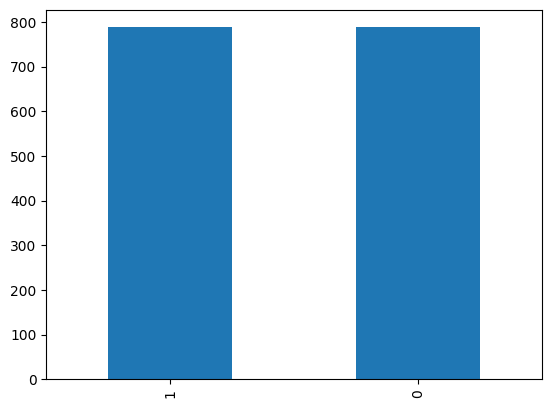

In [260]:
# Convert the resampled data back to a DataFrame
df_resampled = pd.DataFrame(X_train_res, columns= X_train_res.columns)
df_resampled['attended'] = y_train_res

# Print the counts of each class in the 'attended' column
print(df_resampled['attended'].value_counts())
# Count the frequency of each category
attended_counts = df_resampled['attended'].value_counts()

# Create a bar plot
attended_counts.plot(kind='bar')

# Show the plot
plt.show()

**Random forest**

In [261]:
#X_train_res = X_train_res.drop(['attended'], axis=1)

In [283]:
# Create the Random Forest Classifier
rfc2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train a Random Forest classifier on the balanced training data
rfc2.fit(X_train_res, y_train_res)

# Make predictions and print the classification report
y_pred = rfc2.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6956521739130435
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       194
           1       0.49      0.50      0.49        82

    accuracy                           0.70       276
   macro avg       0.64      0.64      0.64       276
weighted avg       0.70      0.70      0.70       276



**SVM**

In [284]:
svc2 = svm.SVC(kernel='linear', random_state=42)

# Fit the model to the training data
svc2.fit(X_train_res, y_train_res)

# Predict the responses for the test set
y_pred = svc2.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7681159420289855
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       194
           1       0.62      0.57      0.59        82

    accuracy                           0.77       276
   macro avg       0.72      0.71      0.72       276
weighted avg       0.76      0.77      0.77       276



## Penalize Algorithms (Cost-Sensitive Training)

**Randome Forest**

In [285]:
# Create the Random Forest Classifier with class_weight='balanced'
rfc3 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the classifier
rfc3.fit(X_train, y_train)

# Make predictions
y_pred = rfc3.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7282608695652174
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       194
           1       0.56      0.41      0.48        82

    accuracy                           0.73       276
   macro avg       0.67      0.64      0.65       276
weighted avg       0.71      0.73      0.72       276



**SVM**

In [286]:
# Create the SVM Classifier with class_weight='balanced'
svc3 = svm.SVC(class_weight='balanced', random_state=42)

# Train the classifier
svc3.fit(X_train, y_train)

# Make predictions
y_pred = svc3.predict(X_test)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5978260869565217
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       194
           1       0.39      0.63      0.48        82

    accuracy                           0.60       276
   macro avg       0.59      0.61      0.58       276
weighted avg       0.67      0.60      0.62       276



## Over sampling

In [342]:
resamp = RandomOverSampler(random_state =42)

In [343]:
X_sam, y_sam = resamp.fit_resample(X_train, y_train)

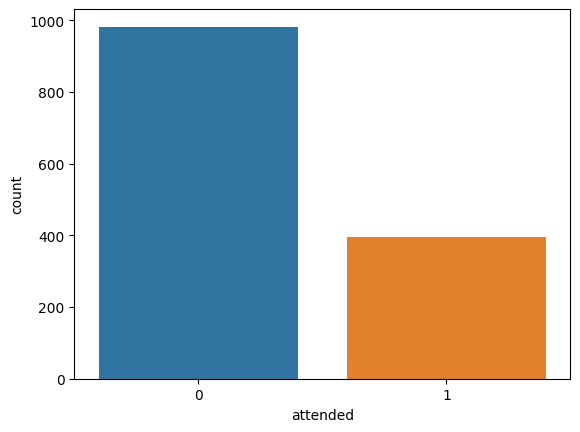

In [184]:
sns.countplot(data=df, x=y)
plt.show()

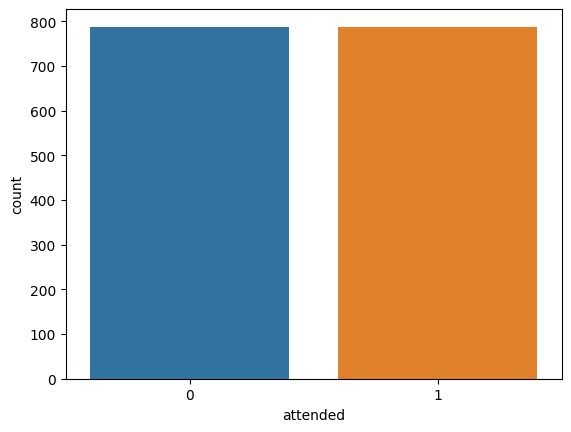

In [185]:
sns.countplot(data=df, x=y_sam)
plt.show()

In [345]:
X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X_sam, y_sam, test_size=0.2, random_state=42)

**Random Forest**

In [346]:
# Create the Random Forest Classifier
rfc_sam = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rfc_sam.fit(X_train_sam, y_train_sam)

# Predict the responses for the test set
y_pred = rfc_sam.predict(X_test_sam)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test_sam, y_pred))
print(classification_report(y_test_sam, y_pred))

Accuracy: 0.8449367088607594
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       171
           1       0.78      0.93      0.85       145

    accuracy                           0.84       316
   macro avg       0.85      0.85      0.84       316
weighted avg       0.86      0.84      0.84       316



**SVM**

In [347]:
# Create the SVM model
svc_sam = svm.SVC(kernel='linear', random_state=42)

# Fit the model to the training data
svc_sam.fit(X_train_sam, y_train_sam)

# Predict the responses for the test set
y_pred = svc_sam.predict(X_test_sam)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test_sam, y_pred))
print(classification_report(y_test_sam, y_pred))

Accuracy: 0.740506329113924
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       171
           1       0.71      0.74      0.72       145

    accuracy                           0.74       316
   macro avg       0.74      0.74      0.74       316
weighted avg       0.74      0.74      0.74       316



## Hyper Tuning

**Random Forest**

In [351]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator = rfc_sam, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_sam, y_train_sam)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

# Train the model using the best parameters
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train_sam, y_train_sam)

# Make predictions and print the classification report
y_pred = rfc.predict(X_test_sam)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test_sam, y_pred))
print(classification_report(y_test_sam, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8544303797468354
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       171
           1       0.81      0.90      0.85       145

    accuracy                           0.85       316
   macro avg       0.86      0.86      0.85       316
weighted avg       0.86      0.85      0.85       316



**SVM**

In [356]:
# Define the parameter values that should be searched
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4], 'kernel': ['poly']}
 ]

# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=5)

# Train the classifier on data1's feature and target data
clf.fit(X_train_res, y_train_res)

# View the best parameters for the model found using grid search
print("Best Parameters:\n", clf.best_params_)

Best Parameters:
 {'C': 1000, 'degree': 2, 'kernel': 'poly'}


In [357]:
# Create the SVM model with the best parameters
svc = svm.SVC(C=1000, kernel='poly', degree= 2, random_state=42)

# Fit the model to the training data
svc.fit(X_train_sam, y_train_sam)

# Predict the responses for the test set
y_pred = svc.predict(X_test_sam)

# Check the accuracy score and classification report
print("Accuracy:", accuracy_score(y_test_sam, y_pred))
print(classification_report(y_test_sam, y_pred))

Accuracy: 0.7310126582278481
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       171
           1       0.69      0.75      0.72       145

    accuracy                           0.73       316
   macro avg       0.73      0.73      0.73       316
weighted avg       0.73      0.73      0.73       316



# Ensimble

**Boosting (Hypothesis Boosting):AdaBoost**

In [358]:
# Create the Random Forest classifier with given parameters
rfc = RandomForestClassifier(
    bootstrap=False, max_depth=None, min_samples_leaf=1,
    min_samples_split=5, n_estimators=200, random_state=42
)

# Use the Random Forest classifier as the base estimator for AdaBoost
ada_clf = AdaBoostClassifier(
    rfc,
    n_estimators=50,  # number of models to iteratively train
    algorithm="SAMME.R",
    learning_rate=0.5  # weight of each model in the final voting process
)

# Train the AdaBoost classifier
ada_clf.fit(X_train_sam, y_train_sam)

# Make predictions
y_pred = ada_clf.predict(X_test_sam)

# Check the accuracy score
print("Accuracy:", accuracy_score(y_test_sam, y_pred))

Accuracy: 0.8575949367088608
